In [1]:
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter

import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix


import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
batch_size = 128
epochs = 50
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
import zipfile
!unzip /content/datasetzip.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [6]:
folder_path = "/content/images/"

In [ ]:
def plot_exp(expression):
    plt.style.use('dark_background')
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)
    plt.show()

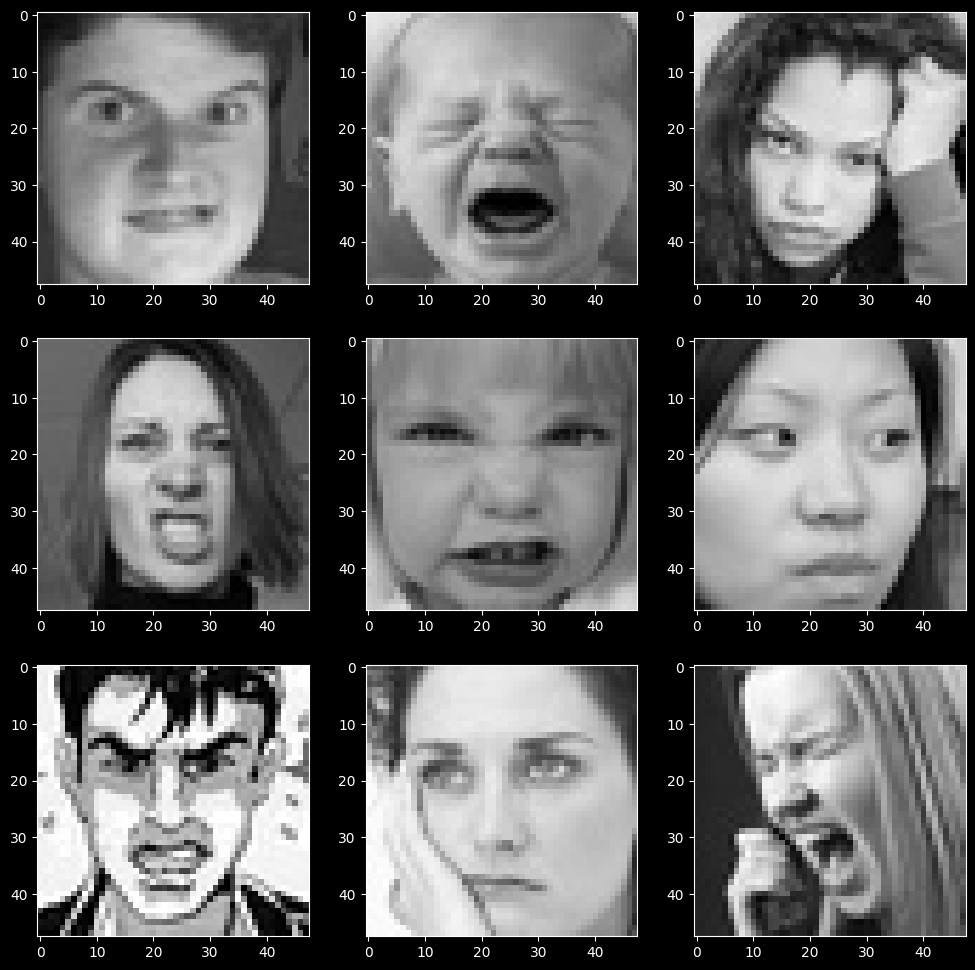

In [ ]:
plot_exp('angry')


In [ ]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [ ]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")

In [ ]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [ ]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'fear': 4103, 'surprise': 3205, 'sad': 4938, 'happy': 7164, 'neutral': 4982, 'disgust': 436, 'angry': 3993}
{'fear': 1018, 'surprise': 797, 'sad': 1139, 'happy': 1825, 'neutral': 1216, 'disgust': 111, 'angry': 960}


In [ ]:
label_train_dict = {'Expressions':train_dict.keys(), 'Count':train_dict.values}
label_val_dict = {'Expressions':val_dict.keys(), 'Count':val_dict.values}

In [ ]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [ ]:
plot_dist(train_dict, "Training data")


In [9]:
plot_dist(val_dict, "Valibation data")

NameError: ignored

In [ ]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


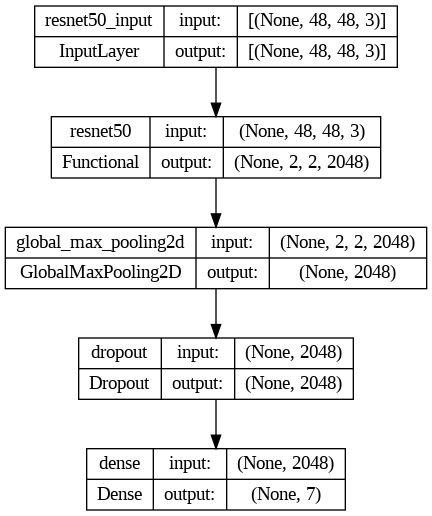

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history = model.fit(train_set,
                    validation_data = test_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = test_set.n//test_set.batch_size,
                   verbose=0)

In [ ]:
predictions = model.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

56/56 [==============================] - 9s 157ms/step


In [ ]:
results = model.evaluate(test_set)
preds   = model.predict(test_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

56/56 [==============================] - 3s 61ms/step
The current model achieved a categorical accuracy of 60.77%!


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


<Figure size 640x480 with 0 Axes>

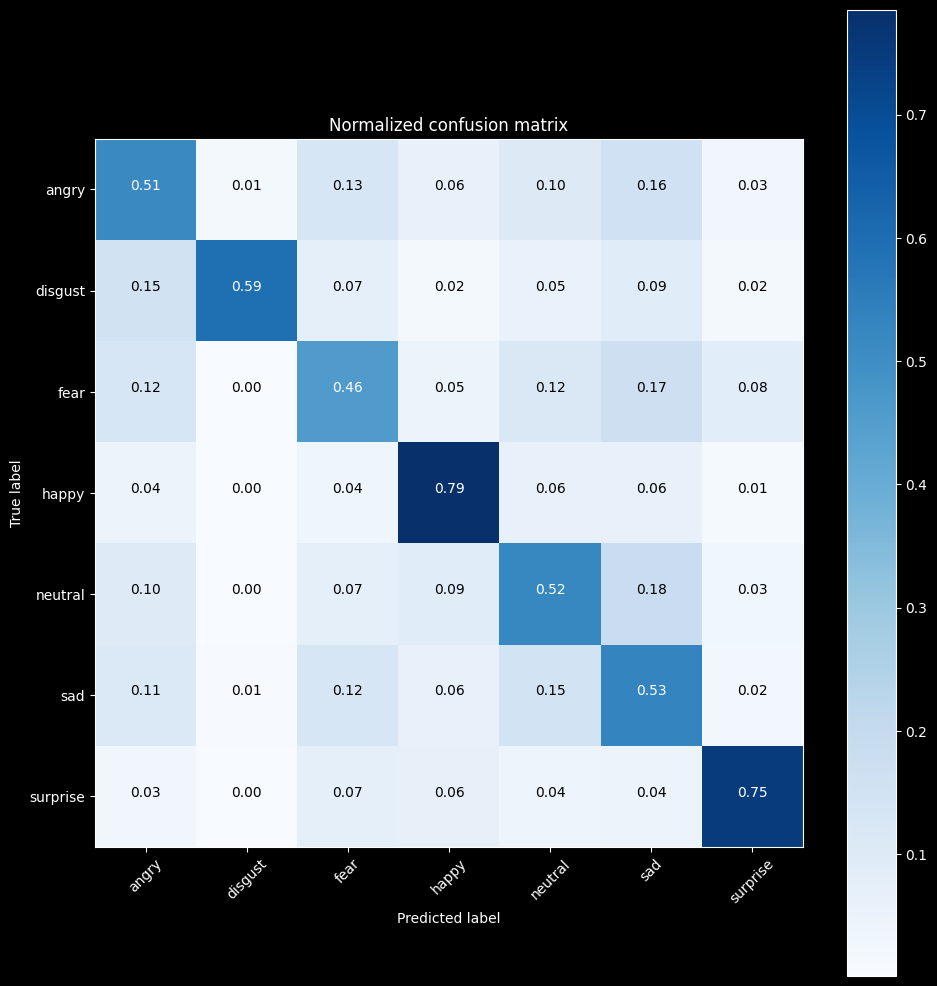

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
class LiveDetection(object):
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.model = tf.keras.models.load_model('FEC_model.h5')
        self.cap = cv2.VideoCapture(0)
        while True:
            self._, self.img = self.cap.read()
            self.img = cv2.flip(self.img, 1)
            self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
            self.faces = self.face_cascade.detectMultiScale(self.gray, 1.1, 4)
            self.class_ = ""
            try:
                for (x, y, w, h) in self.faces:
                    self.face = self.img[y-50:y+h+50, x-50:x+w+50]
                    self.face = cv2.resize(self.face, (48, 48))
                    self.face_array = np.array(self.face)
                    self.face_array = np.expand_dims(self.face_array, axis=0)
                    self.prediction = np.argmax(self.model.predict([self.face_array]), axis=1)
                    self.class_ = indicies[self.prediction[0]]
                    self.font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(self.img, self.class_, (x, y), self.font, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    cv2.rectangle(self.img, (x-25, y-25), (x+w+25, y+h+25), (0, 255, 0), 2)
            except Exception as ex:
                self.class_ = ""
            cv2.imshow('Face Expression Classifier', self.img)
            self.k = cv2.waitKey(1) & 0xff
            if self.k == 27:
                break
        self.cap.release()
if __name__ == "__main__":
    import cv2
    import numpy as np
    import tensorflow as tf
    indicies = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

In [ ]:
model.save("FEC_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [10]:
import os
import numpy as np
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

# Parameters
batch_size = 128
epochs = 50
pic_size = 48
folder_path = "/content/images/"

def load_and_preprocess_data(folder_path, subset):
    datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    data_generator = datagen.flow_from_directory(
        os.path.join(folder_path, subset),
        target_size=(pic_size, pic_size),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=(subset == "train"),
    )

    return data_generator

def calculate_class_weights_and_walk_data(folder_path, subset):
    my_dict = {}
    for root, dirs, files in os.walk(os.path.join(folder_path, subset), topdown=False):
        if len(files) > 0:
            my_dict[root] = len(files)

    counter = Counter(my_dict.keys())
    max_val = float(max(counter.values()))
    class_weights = {class_id: max_val / num_images for class_id, num_images in counter.items()}

    return my_dict, class_weights

# Load and preprocess data
train_set = load_and_preprocess_data(folder_path, "train")
test_set = load_and_preprocess_data(folder_path, "validation")

# Calculate class weights and walk through training directory
train_dict, class_weights = calculate_class_weights_and_walk_data(folder_path, "train")

# Model definition
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_set,
    validation_data=test_set,
    class_weight=class_weights,
    epochs=epochs,
    steps_per_epoch=train_set.n // train_set.batch_size,
    validation_steps=test_set.n // test_set.batch_size,
    verbose=0
)

# Evaluate the model
results = model.evaluate(test_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100, 2)))

# Generate predictions
predictions = model.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

# Plot the normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
94765736/94765736 [==============================] - 1s 0us/step


ValueError: ignored

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
56/56 [==============================] - 3s 58ms/step - loss: 0.5343 - accuracy: 0.6165
The current model achieved a categorical accuracy of 61.65%!
56/56 [==============================] - 4s 61ms/step


<Figure size 640x480 with 0 Axes>

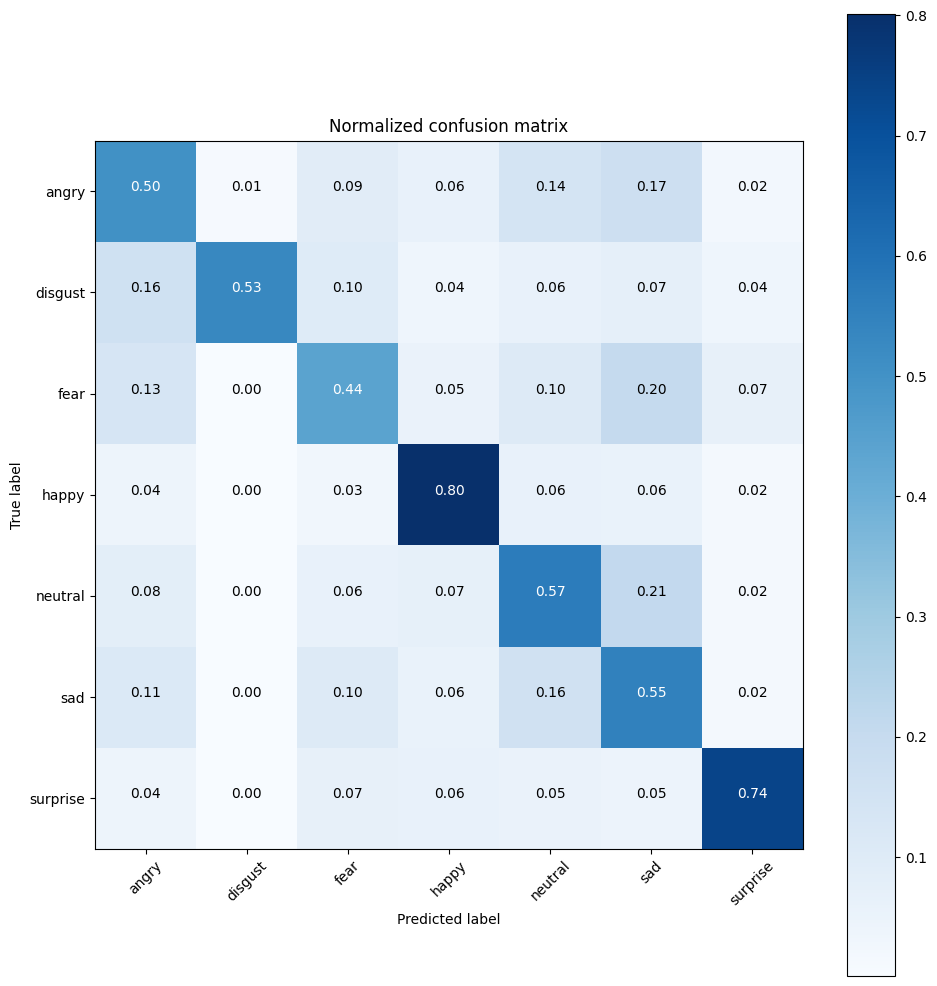

In [13]:
import os
import numpy as np
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

# Parameters
batch_size = 128
epochs = 50
pic_size = 48
folder_path = "/content/images/"

def load_and_preprocess_data(folder_path, subset):
    datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    data_generator = datagen.flow_from_directory(
        os.path.join(folder_path, subset),
        target_size=(pic_size, pic_size),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=(subset == "train"),
    )

    return data_generator

def calculate_class_weights_and_walk_data(folder_path, subset):
    my_dict = {}
    for root, dirs, files in os.walk(os.path.join(folder_path, subset), topdown=False):
        if len(files) > 0:
            my_dict[root] = len(files)

    class_indices = {cls: idx for idx, cls in enumerate(my_dict.keys())}
    counter = Counter(class_indices.keys())
    max_val = float(max(counter.values()))
    class_weights = {class_indices[class_id]: max_val / num_images for class_id, num_images in counter.items()}

    return class_indices, class_weights

# Load and preprocess data
train_set = load_and_preprocess_data(folder_path, "train")
test_set = load_and_preprocess_data(folder_path, "validation")

# Calculate class indices and weights
class_indices, class_weights = calculate_class_weights_and_walk_data(folder_path, "train")

# Model definition
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_set,
    validation_data=test_set,
    class_weight=class_weights,
    epochs=epochs,
    steps_per_epoch=train_set.n // train_set.batch_size,
    validation_steps=test_set.n // test_set.batch_size,
    verbose=0
)

# Evaluate the model
results = model.evaluate(test_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100, 2)))

# Generate predictions
predictions = model.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

# Plot the normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()